In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot
import igraph
import scvelo as scv 
import loompy as lmp
import anndata
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix 
import os 

In [2]:
%pip install scvelo



  Obtaining dependency information for scvelo from https://files.pythonhosted.org/packages/a2/b3/9b683194563b4a9a8c4a3ca2f98dd16217ff7f18495e0bb540028afa0a3a/scvelo-0.3.2-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/4.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/4.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/4.8 MB 320.0 kB/s eta 0:00:16
     ---------------------------------------- 0.0/4.8 MB 217.9 kB/s eta 0:00:23
     ---------------------------------------- 0.0/4.8 MB 217.9 kB/s eta 0:00:23
      --------------------------------------- 0.1/4.8 MB 401.6 kB/s eta 0:00:12
     -------- ------------------------------- 1.0/4.8 MB 3.8 MB/s eta 0:00:02
     ---------------------------------------  4.7/4.8 MB 15.1 MB/s eta 0:00:01
     ---------------------------------------  4.8/4.8 MB 15.4 MB/s eta 0:00:01
     ---------------------------------------- 4.8/4.8 MB 13.4 MB/s eta 0:00:00
  Preparing metadata (set

In [3]:
import loompy
print(loompy.__version__)  # This should print the installed version of loompy

3.0.7


C:\Users\skeam\AppData\Local\anaconda3\Lib\site-packages\loompy\bus_file.py:67: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\skeam\AppData\Local\anaconda3\Lib\site-packages\loompy\bus_file.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\skeam\AppData\Local\anaconda3\Lib\site-packages\loompy\bus_file.py:101: NumbaDeprecationWarni

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.9.6 anndata==0.10.4 umap==0.5.5 numpy==1.24.3 scipy==1.11.1 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.10.8 louvain==0.8.2 pynndescent==0.5.11


In [7]:
results_file = "write/pbmc3k.h5ad"  # the file that will store the analysis results

In [11]:
adata = sc.read_10x_mtx(
    "filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

... reading from cache file cache\filtered_gene_bc_matrices-hg19-matrix.h5ad


In [8]:
adata = sc.read_10x_mtx(
    "sample_filtered_feature_bc_matrix_new/sample/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)   # i think the error is caused by how we arrange the folder

... reading from cache file cache\sample_filtered_feature_bc_matrix_new-sample-matrix.h5ad


In [12]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

normalizing counts per cell
    finished (0:00:00)


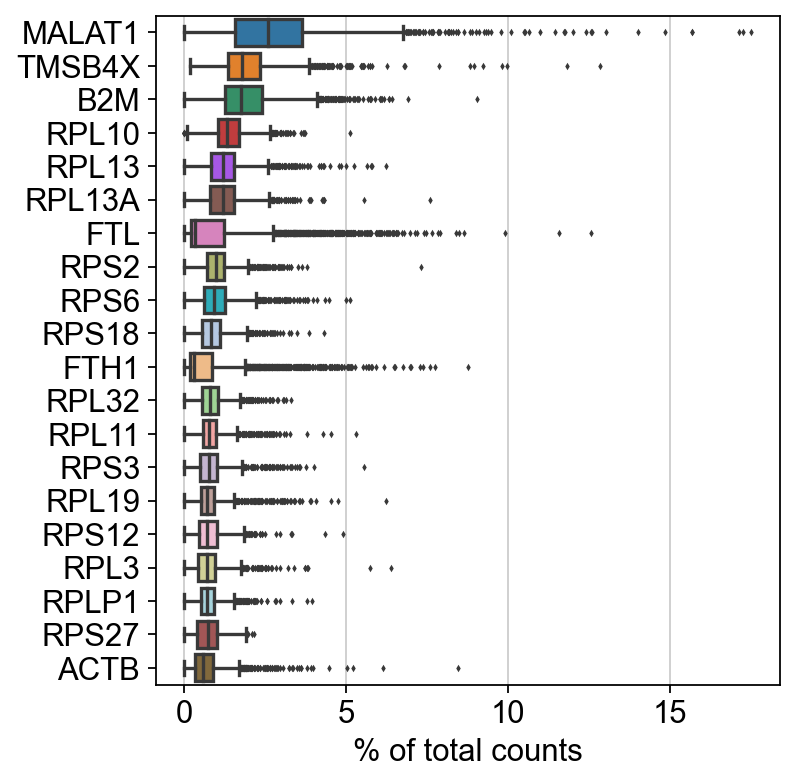

In [13]:
# preprocessing 
sc.pl.highest_expr_genes(adata, n_top=20)

In [38]:
#Basic filtering 
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [39]:
# Let’s assemble some information about mitochondrial genes, which are important for quality control.
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

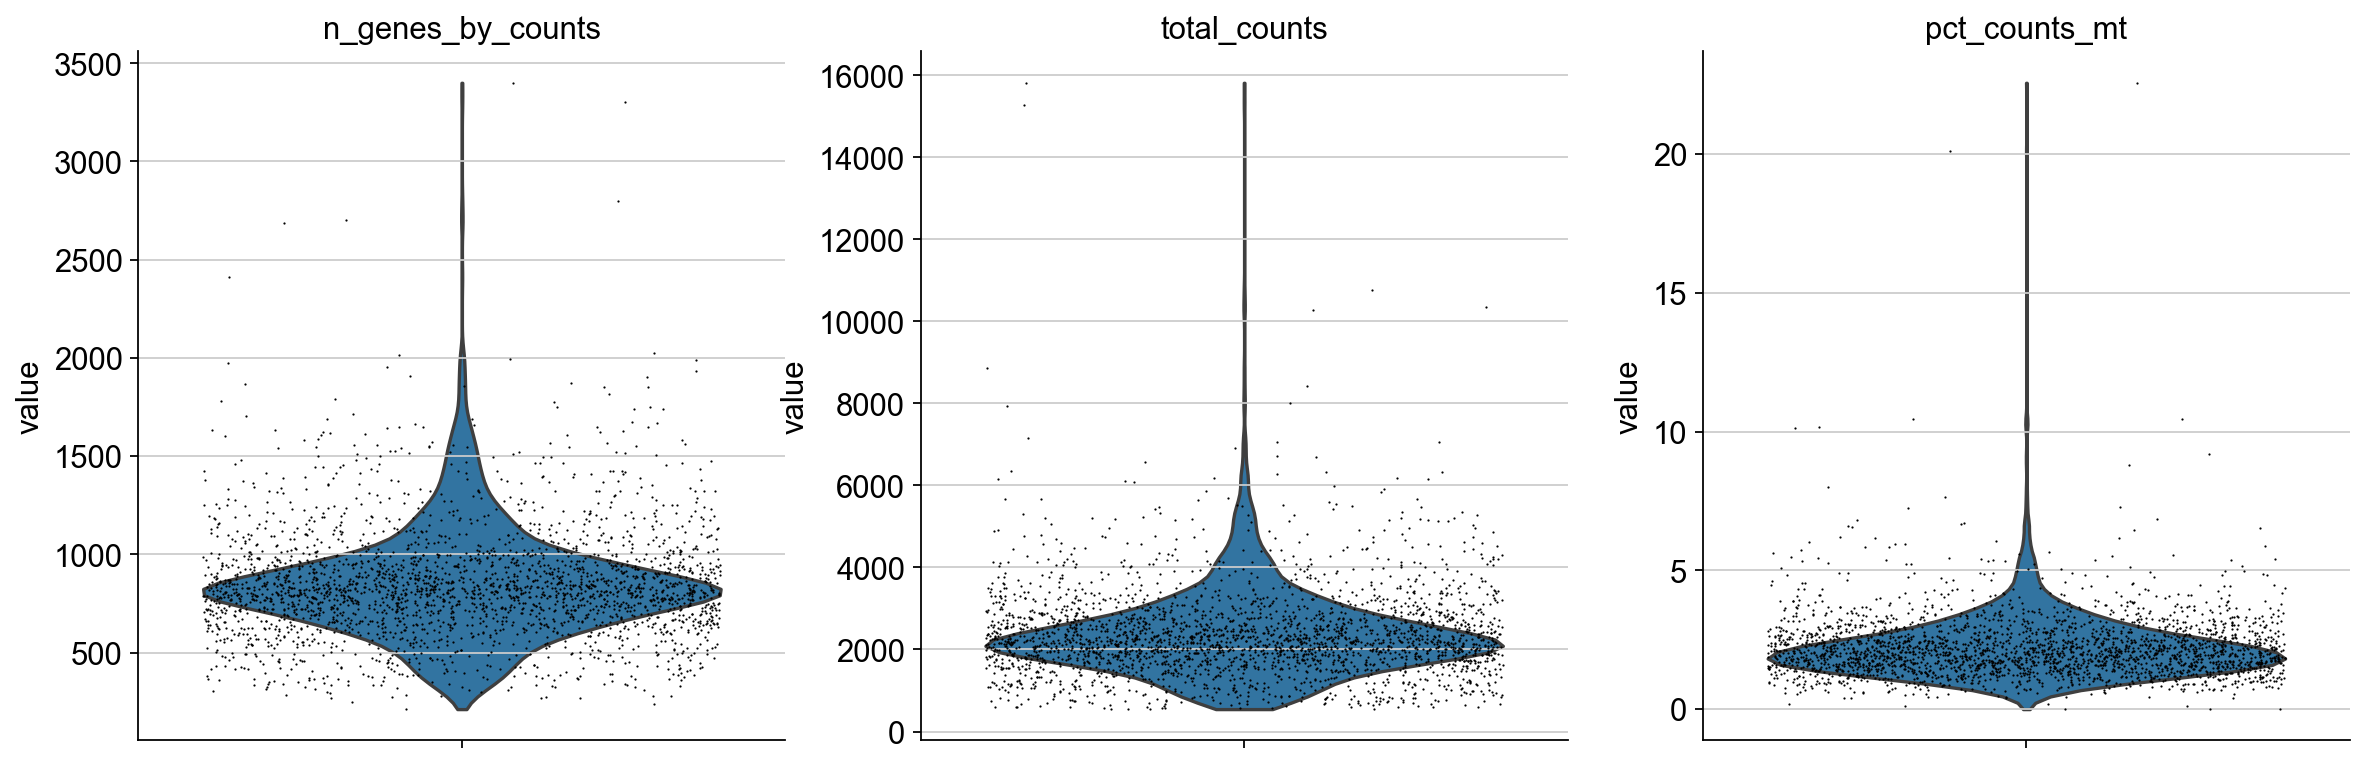

In [40]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

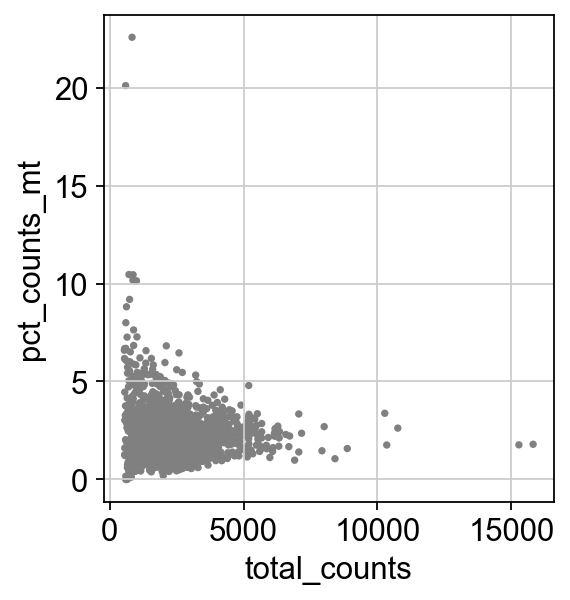

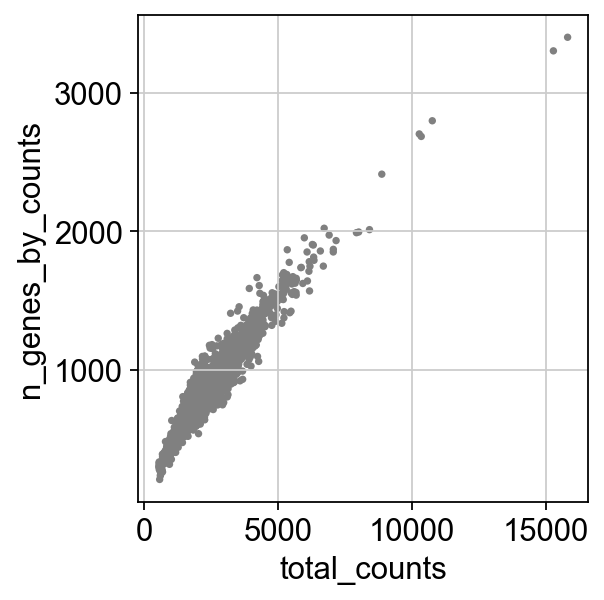

In [41]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [42]:
#Actually do the filtering by slicing the AnnData object.
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [43]:
#Total-count normalize (library-size correct) the data matrix 
# to 10,000 reads per cell, so that counts become comparable among cells. 
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [44]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [45]:
sc.pp.log1p(adata)

In [46]:
#identify highly variable genes 
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


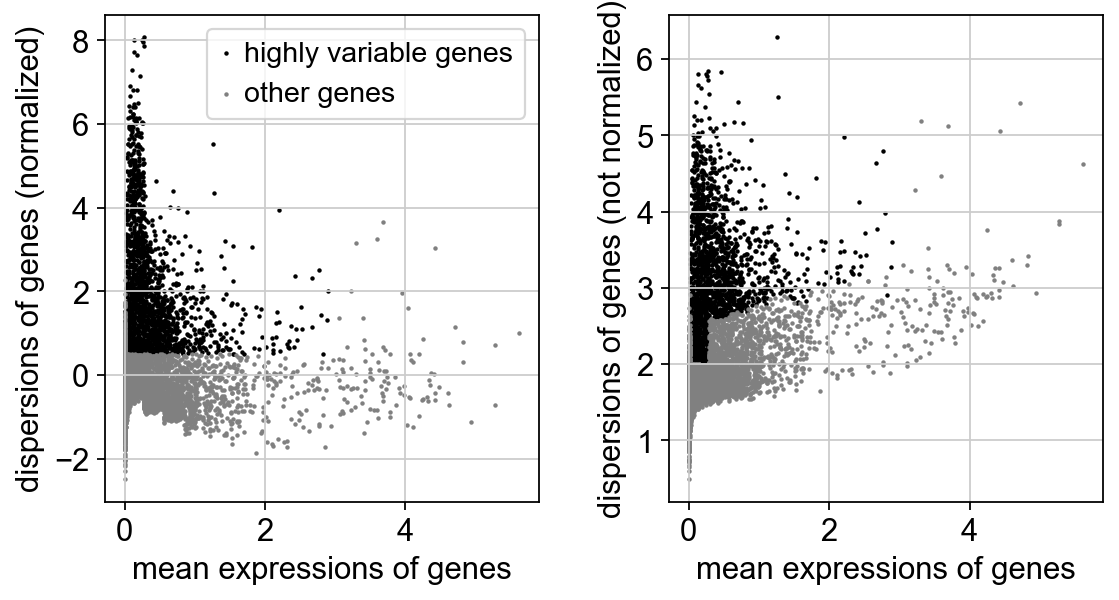

In [47]:
sc.pl.highly_variable_genes(adata)

In [50]:
#Actual filtering 
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:14)


In [51]:
#Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

In [52]:
# Principal component analysis
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


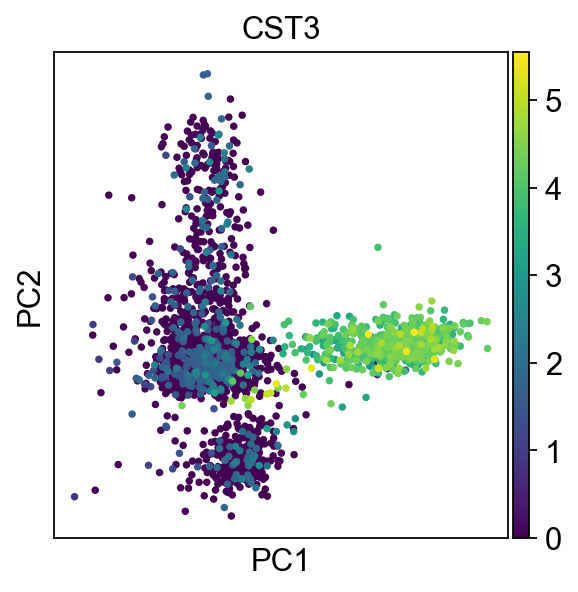

In [53]:
sc.pl.pca(adata, color="CST3")

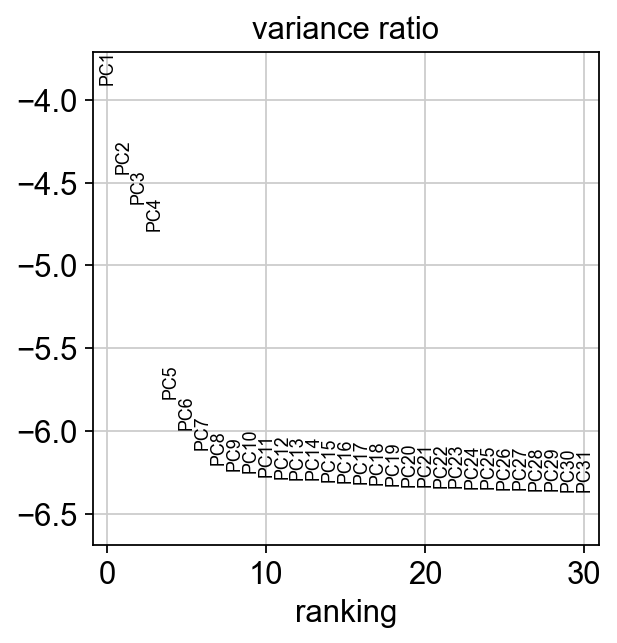

In [54]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
#save result 
adata.write(adata)
adata

In [58]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [59]:
#Computing the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [64]:
# Embedding the neighborhood graph  
sc.tl.leiden(adata, resolution=1.0)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [65]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [66]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


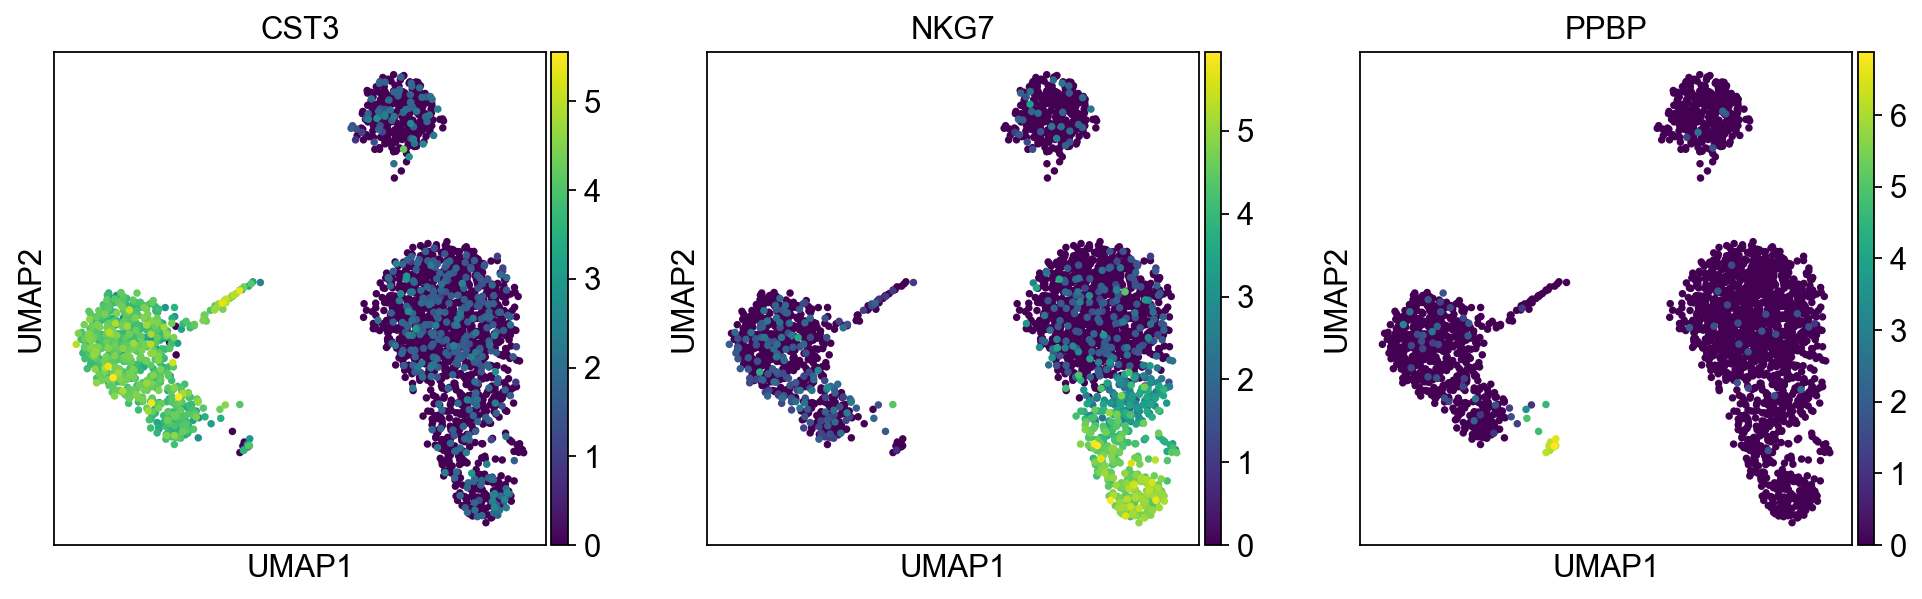

In [67]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])

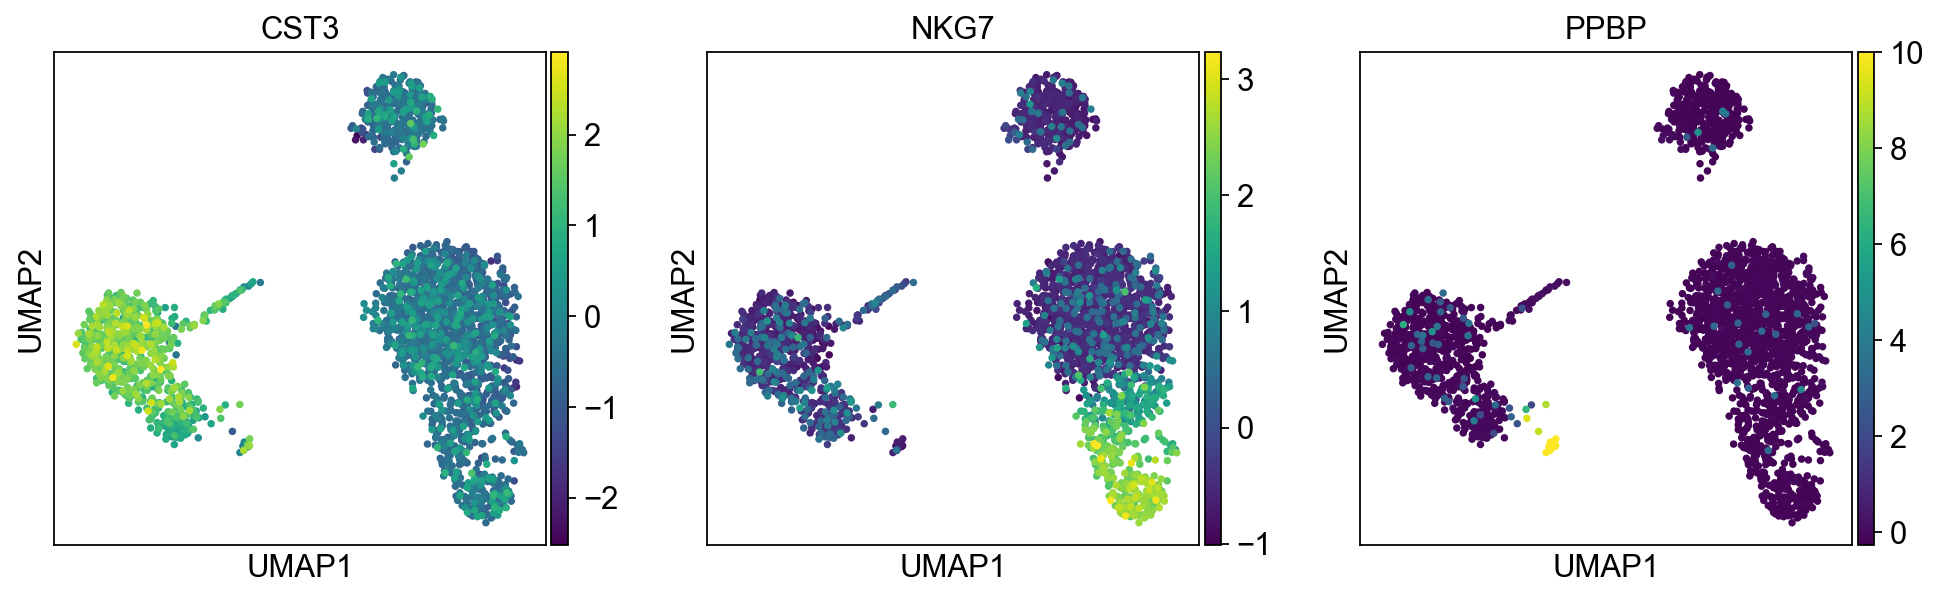

In [68]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], use_raw=False)

In [75]:
#Clustering the neighborhood graph


sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    n_iterations=2,
    directed=False
)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


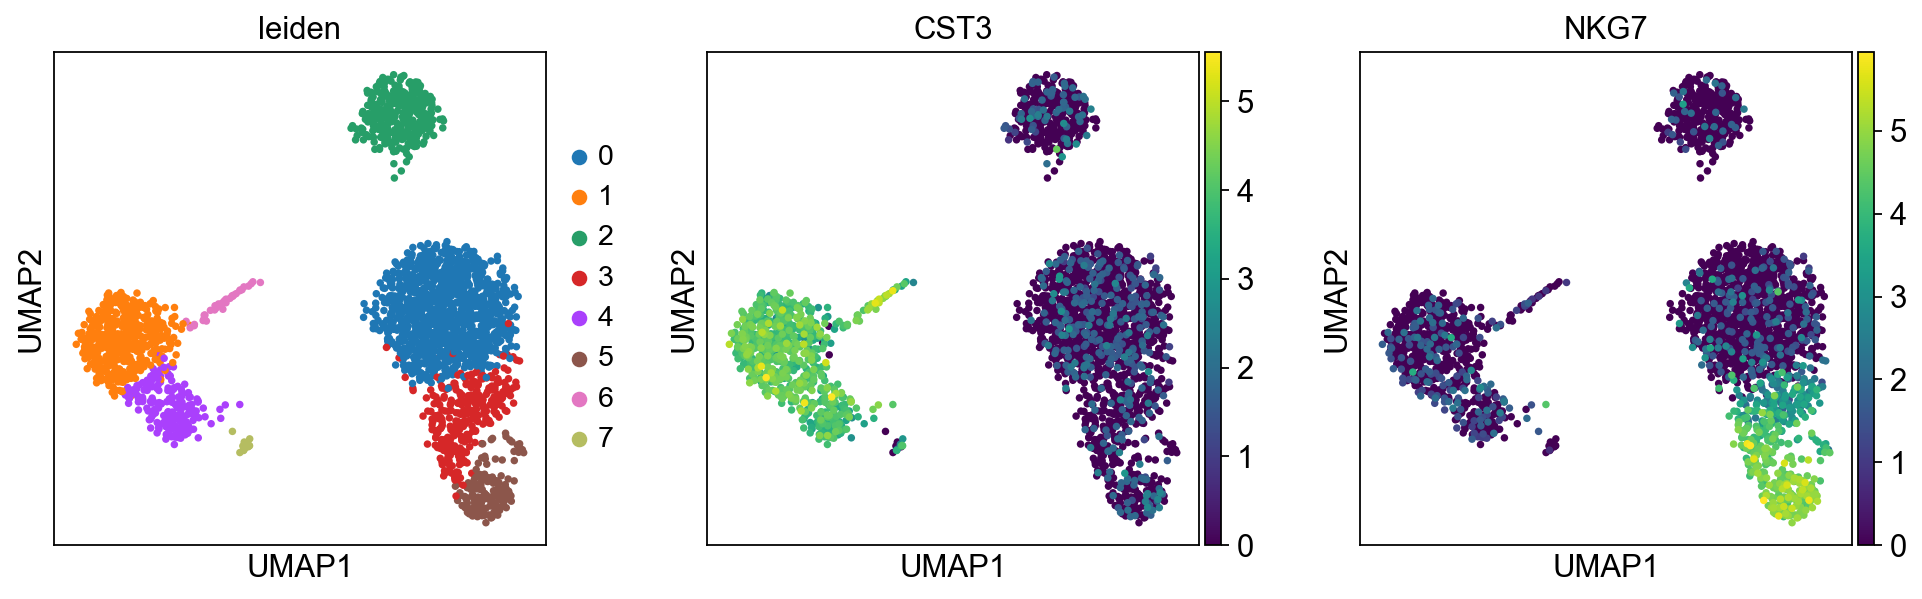

In [74]:
sc.pl.umap(adata, color=["leiden", "CST3", "NKG7"])

In [73]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    n_iterations=2,
)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


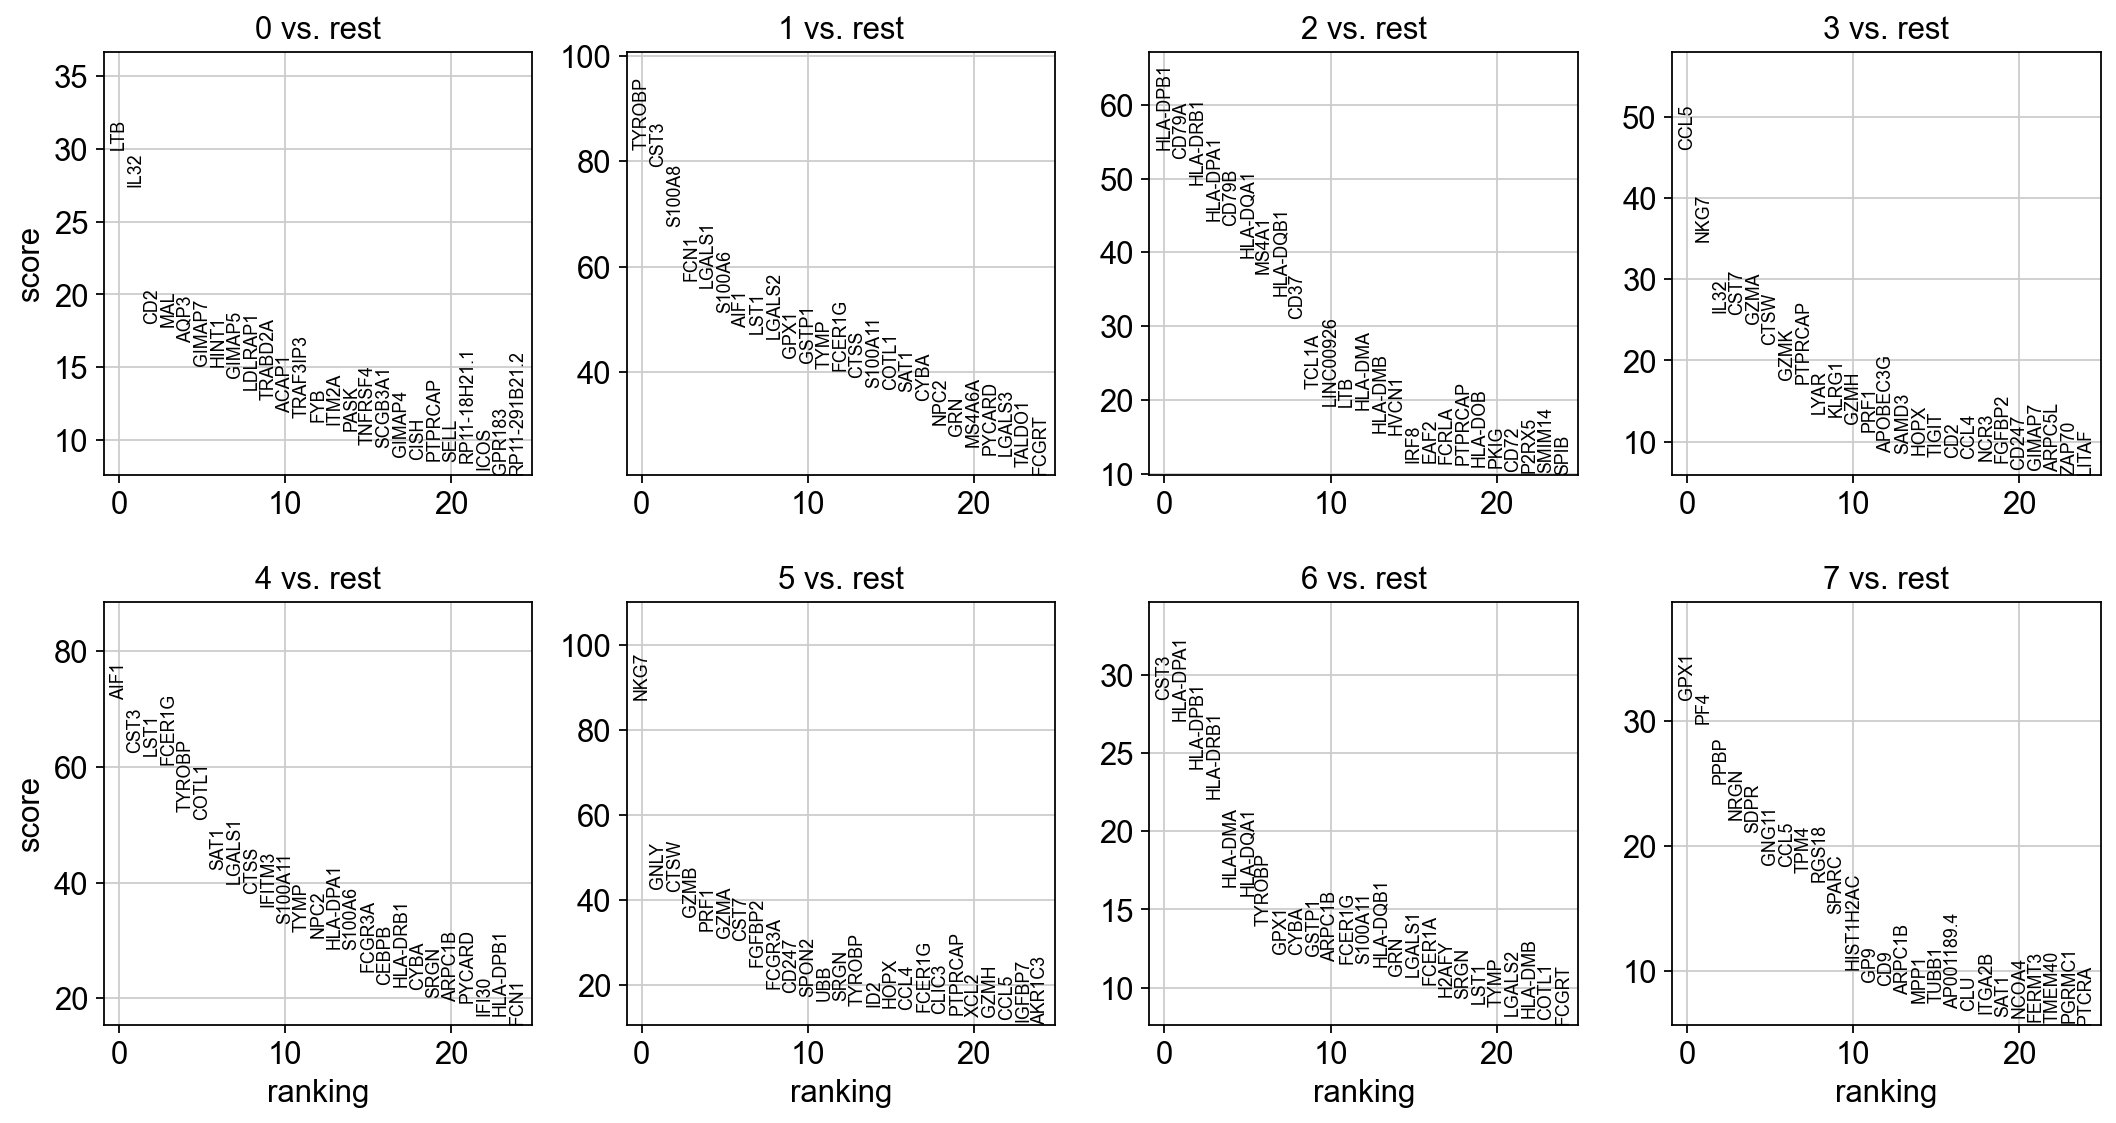

In [76]:
#Finding marker genes 
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [77]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:00)


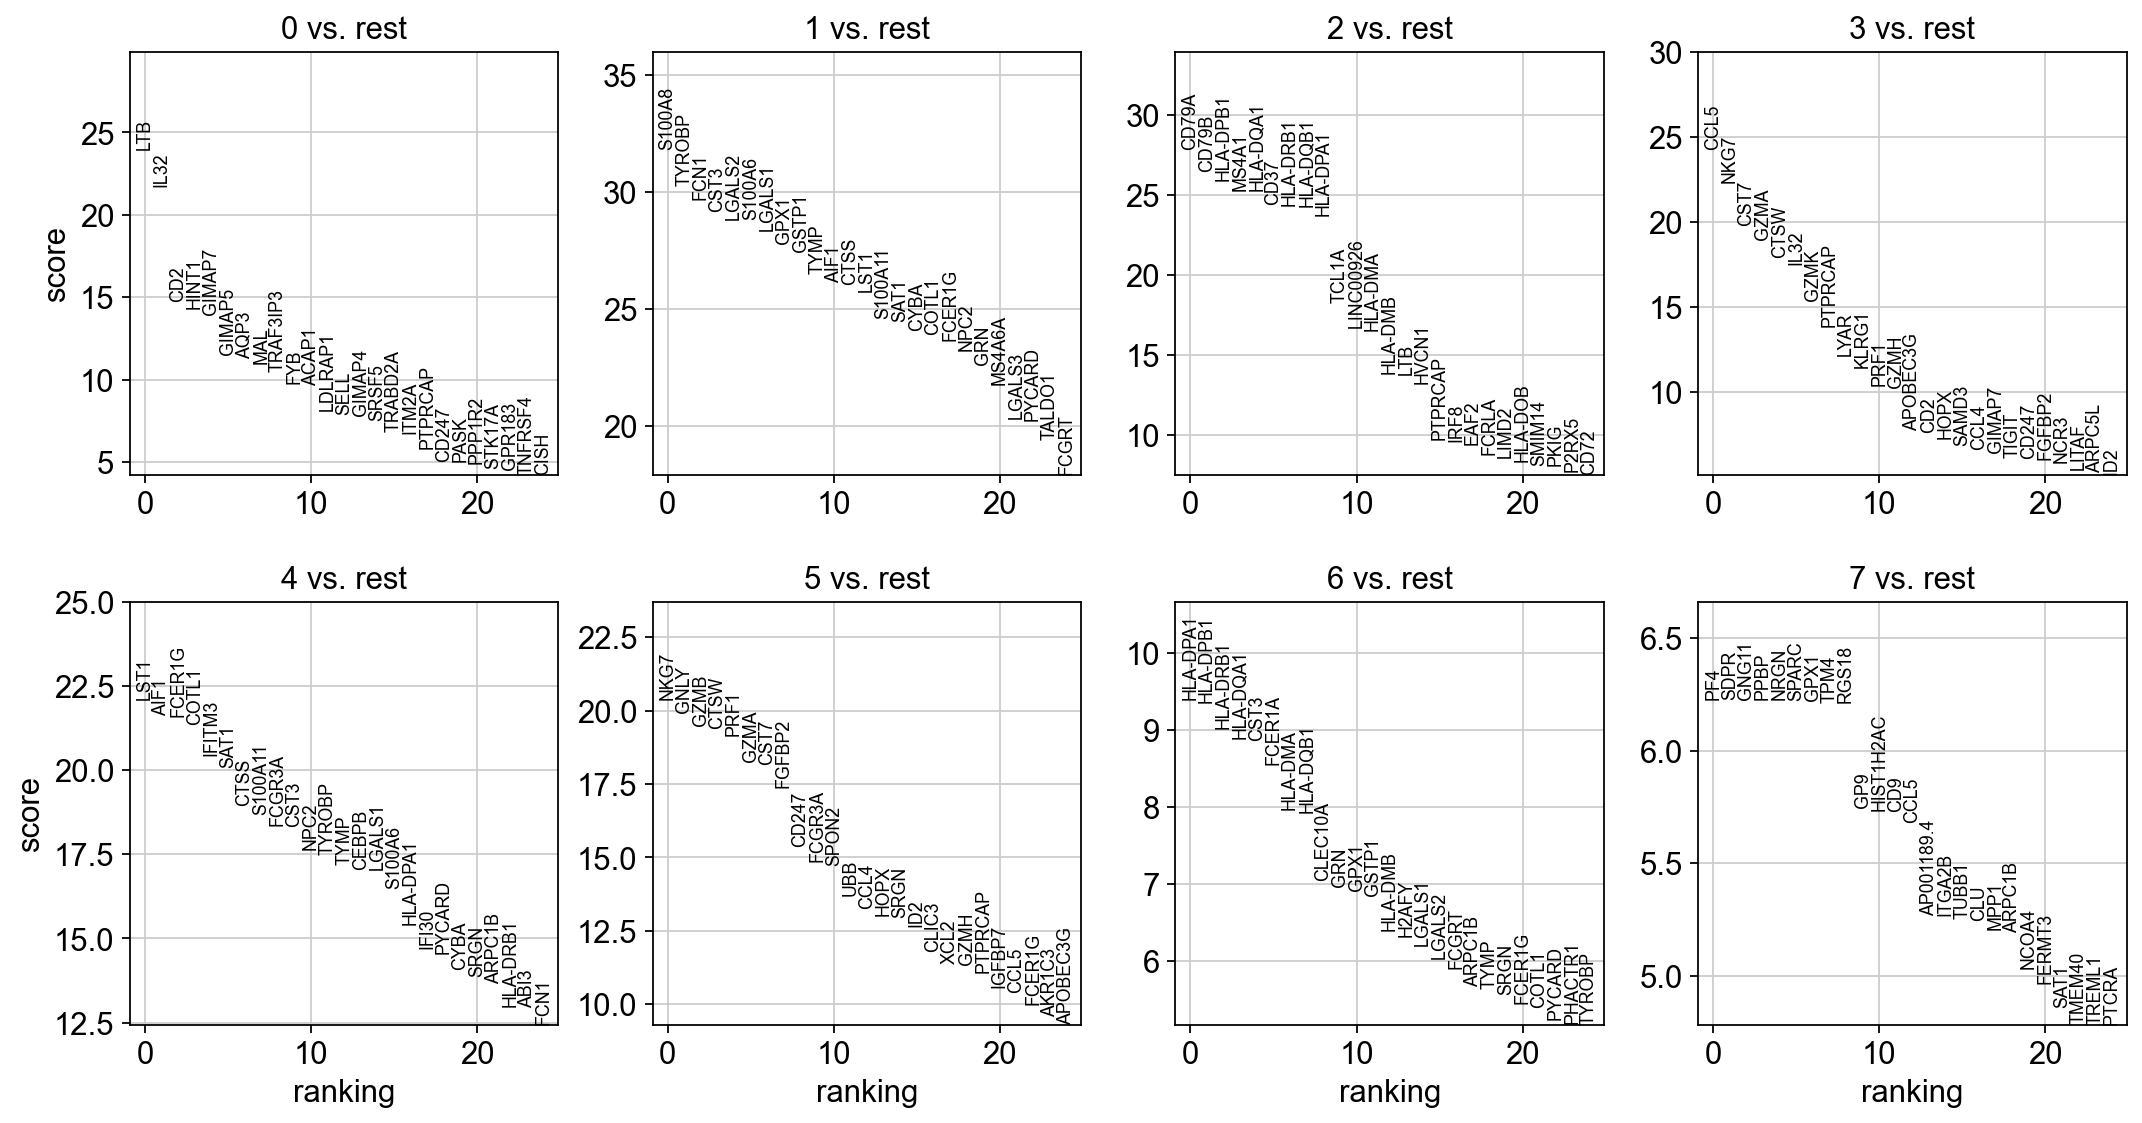

In [78]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [80]:
import os
import scanpy as sc

# Specify the results file path
results_file = 'write/pbmc3k.h5ad'

# Ensure the directory exists
os.makedirs(os.path.dirname(results_file), exist_ok=True)

# Write the AnnData object to the file
adata.write(results_file)

In [81]:
#marker genes 
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

In [82]:
# Reload the object that has been save with the Wilcoxon Rank-Sum test result.
adata = sc.read(results_file)

In [83]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

,0,1,2,3,4,5,6,7
0,LTB,S100A8,CD79A,CCL5,LST1,NKG7,HLA-DPA1,PF4
1,IL32,TYROBP,CD79B,NKG7,AIF1,GNLY,HLA-DPB1,SDPR
2,CD2,FCN1,HLA-DPB1,CST7,FCER1G,GZMB,HLA-DRB1,GNG11
3,HINT1,CST3,MS4A1,GZMA,COTL1,CTSW,HLA-DQA1,PPBP
4,GIMAP7,LGALS2,HLA-DQA1,CTSW,IFITM3,PRF1,CST3,NRGN


In [84]:
# Get a table with the scores and groups.
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,LTB,5.438953e-127,S100A8,4.371848e-222,CD79A,1.677948e-170,CCL5,3.663739e-130,LST1,2.841447e-108,NKG7,1.923512e-92,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,IL32,1.368367e-104,TYROBP,3.202212e-201,CD79B,2.571730e-154,NKG7,2.081480e-110,AIF1,1.244005e-103,GNLY,1.513503e-88,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,CD2,4.168312e-49,FCN1,1.107753e-193,HLA-DPB1,3.577195e-148,CST7,3.760013e-87,FCER1G,2.757131e-103,GZMB,1.405777e-84,HLA-DRB1,1.863229e-19,GNG11,4.733899e-10
3,HINT1,1.451836e-46,CST3,3.576221e-187,MS4A1,6.286899e-141,GZMA,1.855819e-80,COTL1,2.599629e-101,CTSW,7.510027e-84,HLA-DQA1,5.882263e-19,PPBP,4.744938e-10
4,GIMAP7,4.070318e-44,LGALS2,1.342476e-182,HLA-DQA1,8.031401e-141,CTSW,8.880481e-72,IFITM3,8.850934e-93,PRF1,1.054273e-81,CST3,8.003226e-19,NRGN,4.800511e-10


ranking genes
    finished (0:00:00)


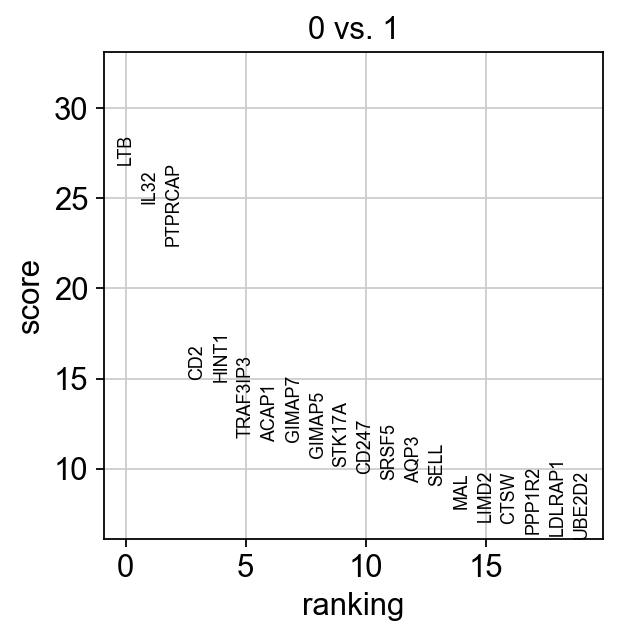

In [85]:
# Compare to a single cluster:
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

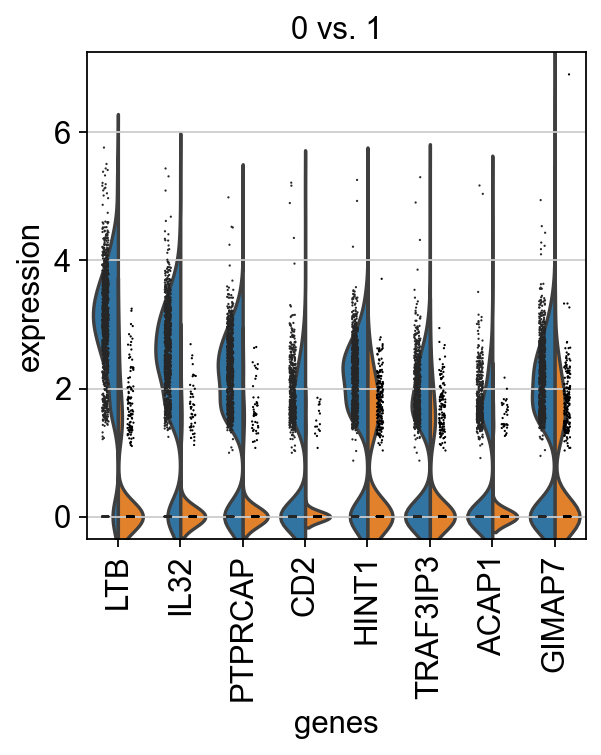

In [86]:
#If we want a more detailed view for a certain group, use sc.pl.rank_genes_groups_violin.

sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

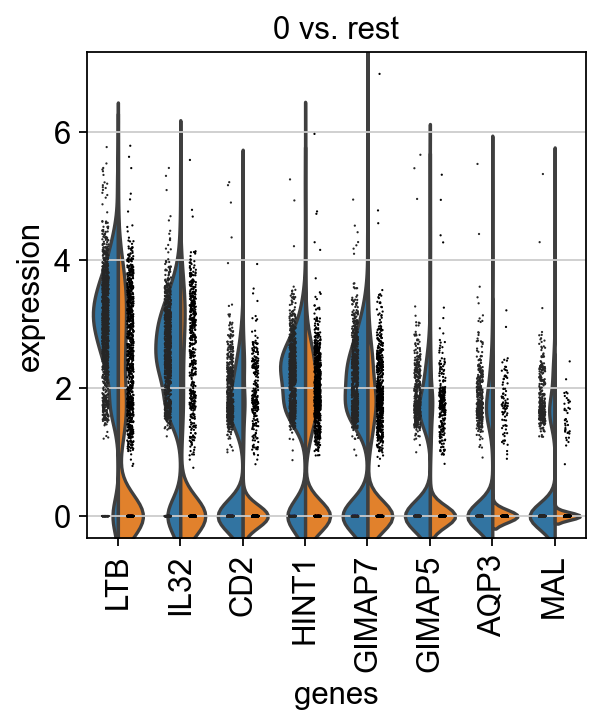

In [88]:
# Reload the object with the computed differential expression (i.e. DE via a comparison with the rest of the groups): 
adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

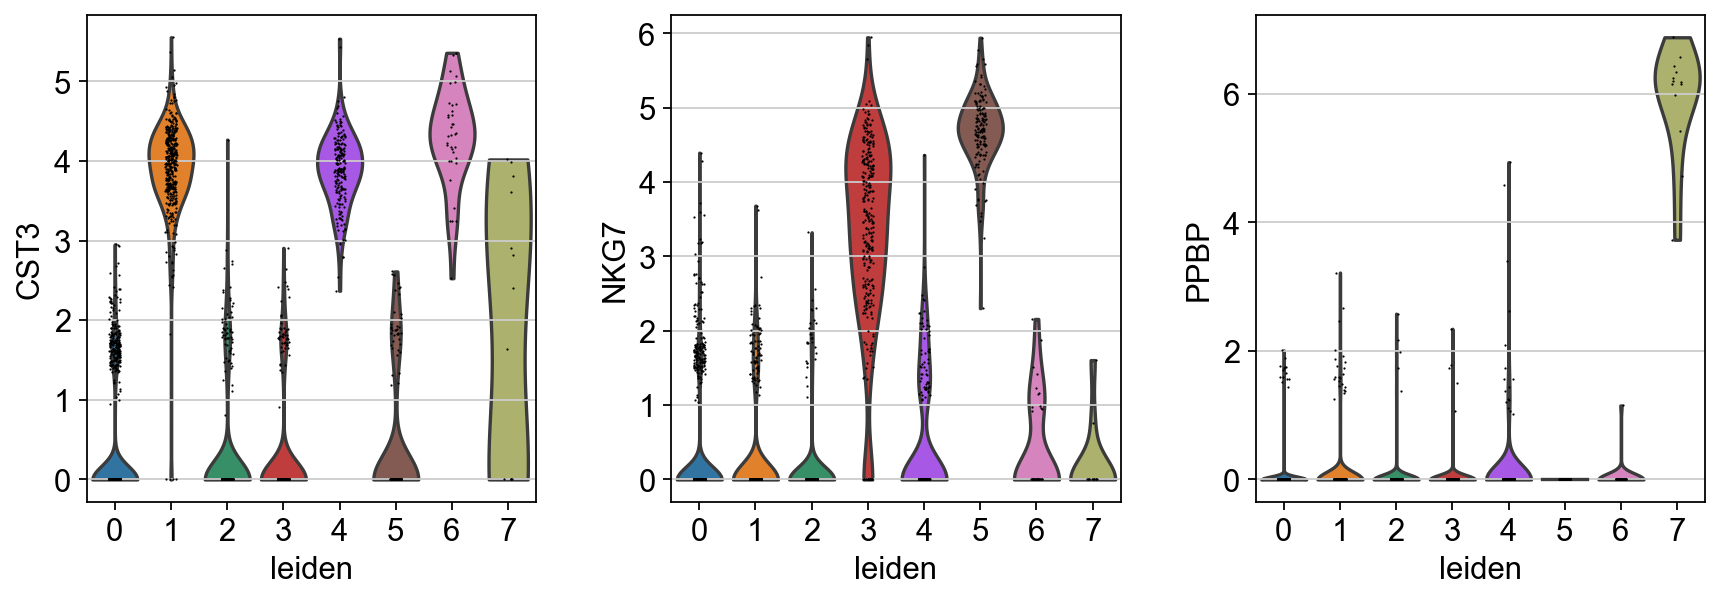

In [89]:
#If you want to compare a certain gene across groups, use the following.
sc.pl.violin(adata, ["CST3", "NKG7", "PPBP"], groupby="leiden")

In [90]:
# Actually mark the cell types.
new_cluster_names = [
    "CD4 T",
    "B",
    "FCGR3A+ Monocytes",
    "NK",
    "CD8 T",
    "CD14+ Monocytes",
    "Dendritic",
    "Megakaryocytes",
]
adata.rename_categories("leiden", new_cluster_names)

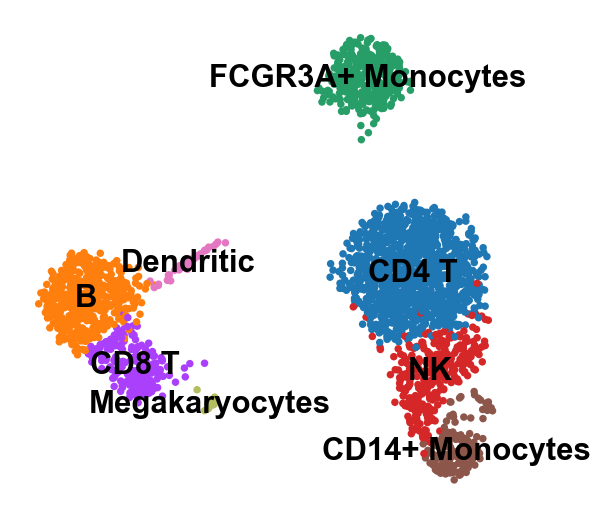

In [91]:
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf"
)

In [94]:
# Now that we annotated the cell types, let us visualize the marker genes. 
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

In [96]:
# Now that we annotated the cell types, let us visualize the marker genes. 
marker_genes = [
    *["CD79A", "MS4A1"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "FCER1A", "CST3", "PPBP"],
]

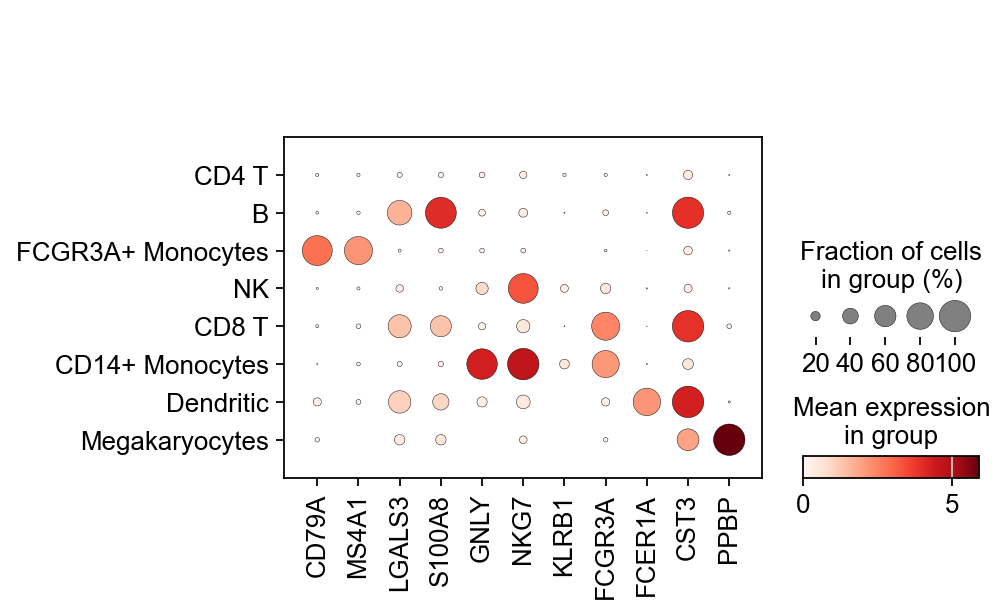

In [97]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden");

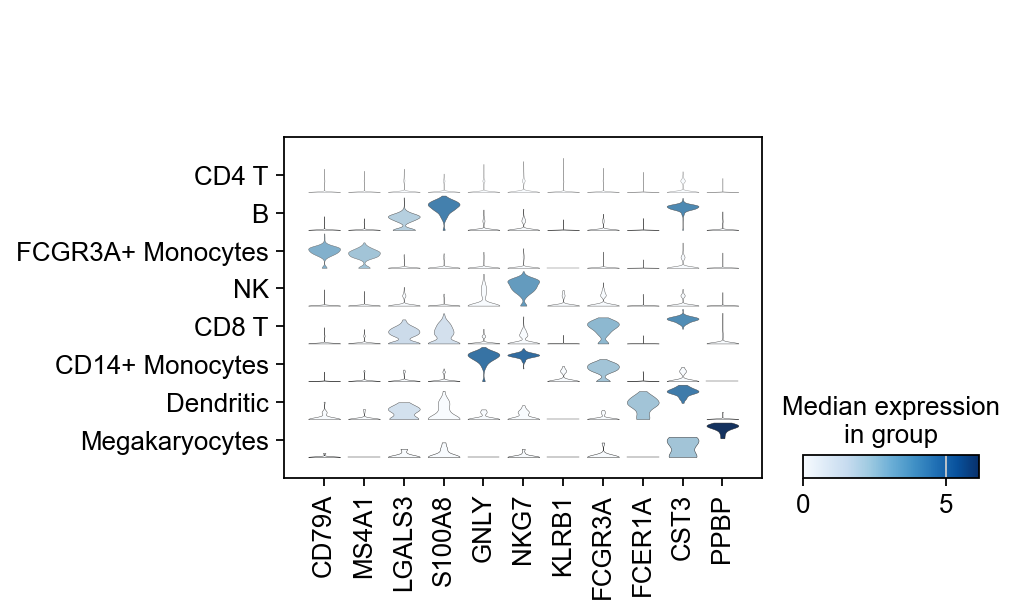

In [98]:
sc.pl.stacked_violin(adata, marker_genes, groupby="leiden");

In [99]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [100]:
# `compression='gzip'` saves disk space, and slightly slows down writing and subsequent reading
adata.write(results_file, compression="gzip")

In [101]:
adata.raw.to_adata().write("./write/pbmc3k_withoutX.h5ad")